In [1]:
## import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import pointbiserialr



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_l

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\eilee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_l

AttributeError: _ARRAY_API not found

In [ ]:
# download packages
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eilee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eilee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eilee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from pathlib import Path
import sys

sys.path.append(str(Path().resolve().parent))
from data_preprocessing.preprocessing import preprocessing

df_raw = pd.read_csv('../Data/Raw/Job_Frauds.csv', encoding='latin-1')
df = preprocessing(df_raw)

C:\Users\eilee\OneDrive - National University of Singapore\DSA4263\DSA4263-Project\data_preprocessing\preprocessing.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


## Handling Missing Values

In [17]:
# Replace empty string, empty list as NaN
def replace_empty_values(x):
    if isinstance(x, str) and x.strip() == '':
        return np.nan
    elif isinstance(x, list) and len(x) == 0:
        return np.nan
    elif isinstance(x, (list, np.ndarray)) and len(x) == 0:
        return np.nan
    elif x is None:
        return np.nan
    else:
        return x

df = df.map(lambda x: replace_empty_values(x))

print(df.isna().sum())

Job Title                 0
Department            11553
Range_of_Salary       15012
Profile                3308
Job_Description           1
Requirements           2701
Job_Benefits           7217
Telecomunication          0
Comnpany_Logo             0
Type_of_Employment     3471
Experience             7050
Qualification          8105
Type_of_Industry       4903
Operations             6455
Fraudulent                0
Country                 346
State                  2580
City                   2068
dtype: int64


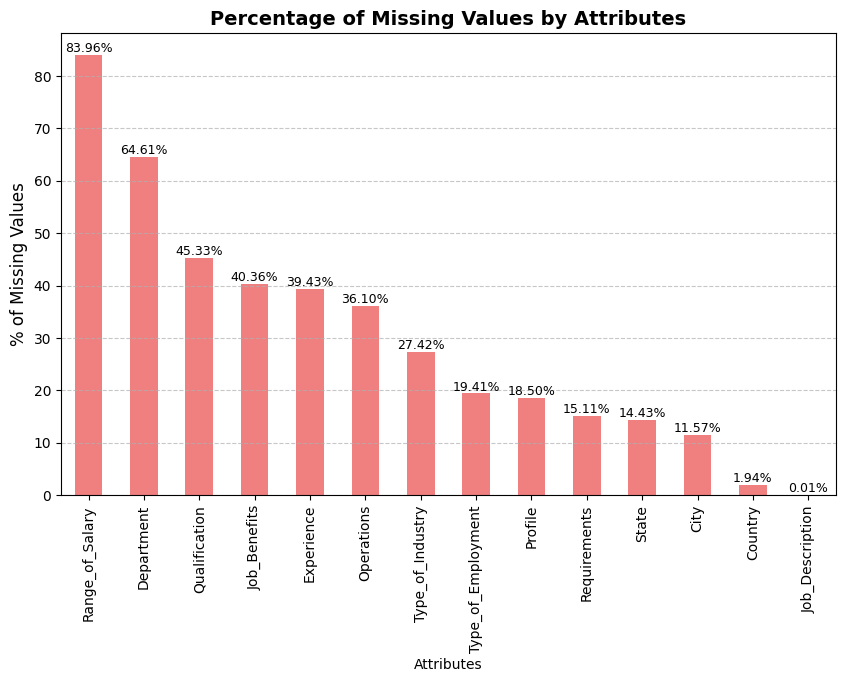

In [18]:
# Distribution of missing values across attributes

missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = missing_percent.plot(kind='bar', color='lightcoral')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.title('Percentage of Missing Values by Attributes', fontsize=14, fontweight='bold')
plt.ylabel('% of Missing Values', fontsize=12)
plt.xlabel('Attributes', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [19]:
# 'Country' and 'Job_Description' have a very low percentage of missing values, so can be removed safely

df= df.dropna(subset=['Job_Description','Country'])

print(df.isnull().sum())

# dropped about 347 out of 17880 rows (1.94% of total rows)

Job Title                 0
Department            11257
Range_of_Salary       14687
Profile                3245
Job_Description           0
Requirements           2524
Job_Benefits           6966
Telecomunication          0
Comnpany_Logo             0
Type_of_Employment     3256
Experience             6796
Qualification          7820
Type_of_Industry       4654
Operations             6192
Fraudulent                0
Country                   0
State                  2234
City                   1722
dtype: int64


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17533 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Job Title           17533 non-null  object
 1   Department          6276 non-null   object
 2   Range_of_Salary     2846 non-null   object
 3   Profile             14288 non-null  object
 4   Job_Description     17533 non-null  object
 5   Requirements        15009 non-null  object
 6   Job_Benefits        10567 non-null  object
 7   Telecomunication    17533 non-null  int64 
 8   Comnpany_Logo       17533 non-null  int64 
 9   Type_of_Employment  14277 non-null  object
 10  Experience          10737 non-null  object
 11  Qualification       9713 non-null   object
 12  Type_of_Industry    12879 non-null  object
 13  Operations          11341 non-null  object
 14  Fraudulent          17533 non-null  int64 
 15  Country             17533 non-null  object
 16  State               15299 n

             Attribute  Correlation        P-Value  Adjusted P-Value
0           Department    -0.016750   2.655870e-02      3.541160e-02
1      Range_of_Salary    -0.060394   1.207793e-15      7.246756e-15
2              Profile     0.284009  1.482197e-322     1.778636e-321
3         Requirements     0.014566   5.377038e-02      6.452445e-02
4         Job_Benefits     0.005372   4.768899e-01      4.768899e-01
5   Type_of_Employment     0.048520   1.293554e-10      3.880662e-10
6           Experience     0.049755   4.345067e-11      1.738027e-10
7        Qualification     0.030878   4.325628e-05      7.415362e-05
8     Type_of_Industry     0.022564   2.808936e-03      4.213404e-03
9           Operations     0.012376   1.012869e-01      1.104948e-01
10               State    -0.034158   6.068225e-06      1.213645e-05
11                City     0.048212   1.690068e-10      4.056162e-10
Missing Value Not significant: ['Requirements', 'Job_Benefits', 'Operations']


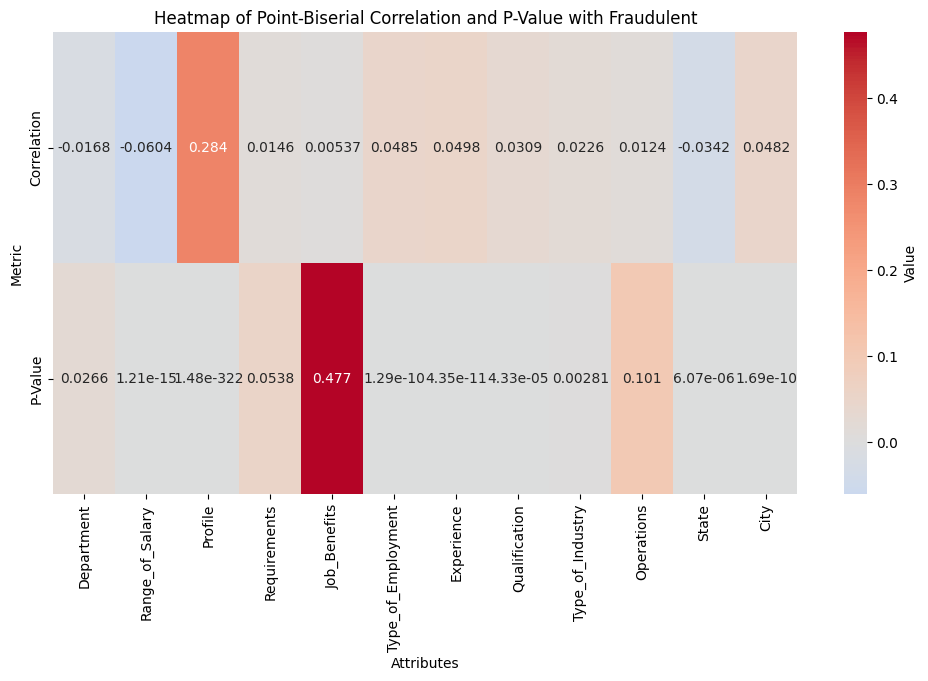

In [21]:
# Compute the correlation and p-value between missing values and 'Fraudulent' occurrences.

# Create Missing Value Indicators (1 if missing, 0 if present)
missing_indicators = df.isna().astype(int)

correlation_results = []

for col in df.columns:
    if col != 'Fraudulent' and missing_indicators[col].sum() > 0:
        # Compute Point-Biserial Correlation and P-Value
        corr, p_value = pointbiserialr(missing_indicators[col], df['Fraudulent'])
        correlation_results.append([col, corr, p_value])

correlation_df = pd.DataFrame(correlation_results, columns=['Attribute', 'Correlation', 'P-Value'])

# Apply False Discovery Rate (FDR) correction for multiple testing
correlation_df['Adjusted P-Value'] = multipletests(correlation_df['P-Value'], method='fdr_bh')[1]
print(correlation_df)

non_significant_columns = correlation_df[correlation_df['Adjusted P-Value'] > 0.05]['Attribute'].tolist()
print("Missing Value Not significant:", non_significant_columns)

# Heatmap Plot
correlation_pvalue_df = correlation_df[['Attribute', 'Correlation', 'P-Value']].set_index('Attribute')
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_pvalue_df.T, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Value'}, fmt='.3g')

plt.xlabel('Attributes')
plt.ylabel('Metric')
plt.title('Heatmap of Point-Biserial Correlation and P-Value with Fraudulent')
plt.show()

In [22]:
# Replace null values with 'Unspecified' category

df = df.fillna("Unspecified")

In [23]:
# Exploring 'Range of Salary'

df['Range_of_Salary'].unique()


array(['Unspecified', '2000028000', '100000120000', '120000150000',
       '5000065000', '4000050000', '6080', '6500070000', '75115',
       '75000110000', '1700020000', '1600028000', '95000115000',
       '1500018000', '5000070000', '4500060000', '3000040000',
       '7000090000', '1000014000', '50110', '2800045000', '034300',
       '3500040000', '09dec', '4400057000', '1850028000', '5500075000',
       '3000035000', '00', '2000040000', '360000600000', '5000080000',
       '80000100000', '5200078000', '1575015750', '4000065000',
       '4500050000', '3000037000', '4500067000', '35000100000',
       '180000216000', '4500065000', '2800032000', '01000', '3600040000',
       '80000110000', '3500073000', '1900019000', '60000120000',
       '12000015000000', '4200055000', '90000120000', '100000150000',
       '2800038000', '16001700', '5000060000', '3000070000', '3200040000',
       '50100', '900017000', '2304028800', '100000180000', '4500055000',
       '900012000', '5000090000', '2500042

In [24]:
# Percentage of invalid entries like '8Nov'

filtered_df = df.loc[df['Range_of_Salary'] != 'Unspecified'].copy()
# Convert to numeric (invalid values become NaN)
filtered_df.loc[:, 'Salary_Numeric'] = pd.to_numeric(filtered_df['Range_of_Salary'], errors='coerce')
percent_invalid = (filtered_df['Salary_Numeric'].isna().sum() /  len(filtered_df)) * 100

print(f"Percentage of invalid salary entries: {percent_invalid:.2f}%")



Percentage of invalid salary entries: 0.84%


In [116]:
# maybe can remove the invalid entries as the percentage is very low

## EDA

Barplot for Fraudulent Postings by Employment Type

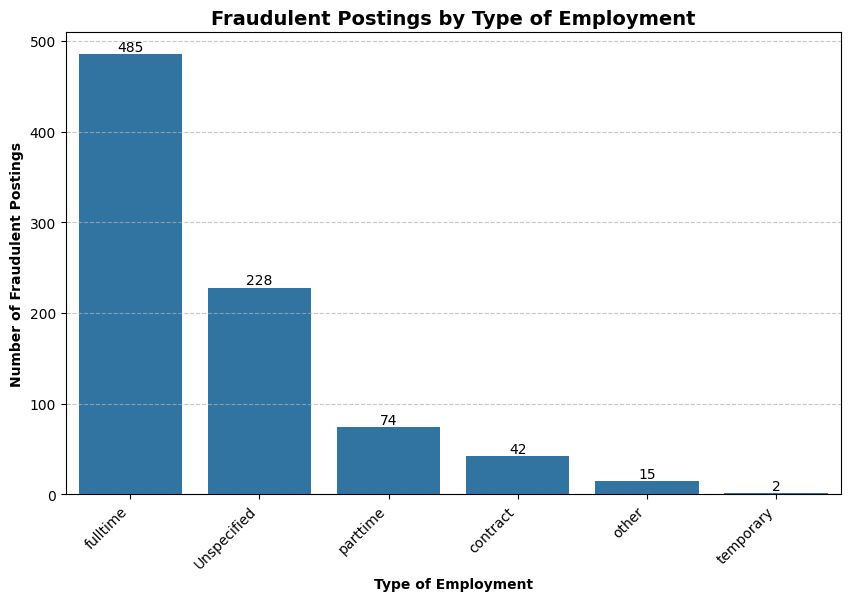

In [117]:
sorted_employment = df.groupby('Type_of_Employment')['Fraudulent'].sum().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Type_of_Employment', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_employment)
plt.title('Fraudulent Postings by Type of Employment', fontsize=14, fontweight='bold')
plt.xlabel('Type of Employment', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()


Barplot for Fraudulent Postings by Experience

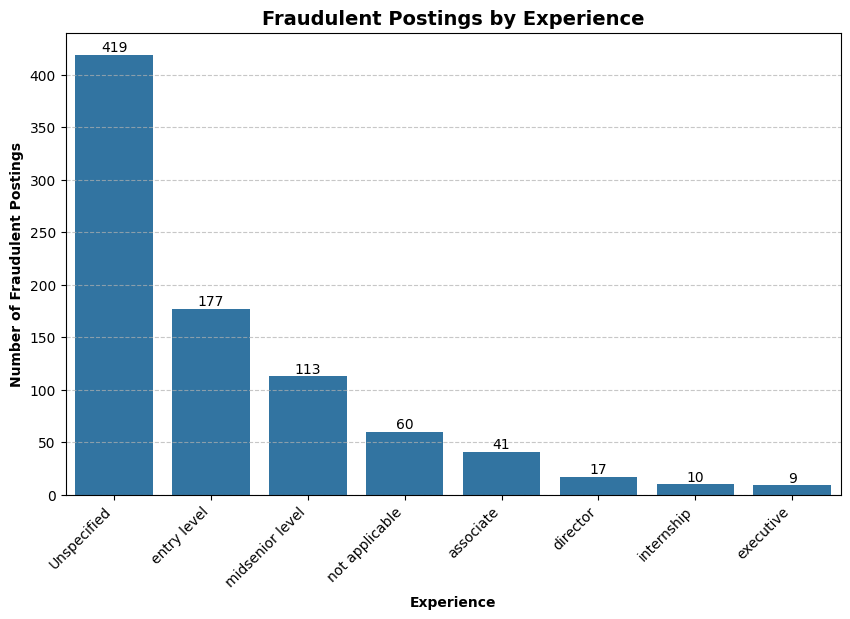

In [118]:

sorted_experience = df.groupby('Experience')['Fraudulent'].sum().sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Experience', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_experience)
plt.title('Fraudulent Postings by Experience', fontsize=14, fontweight='bold')
plt.xlabel('Experience', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()


Barplot for Fraudulent Postings by Qualification

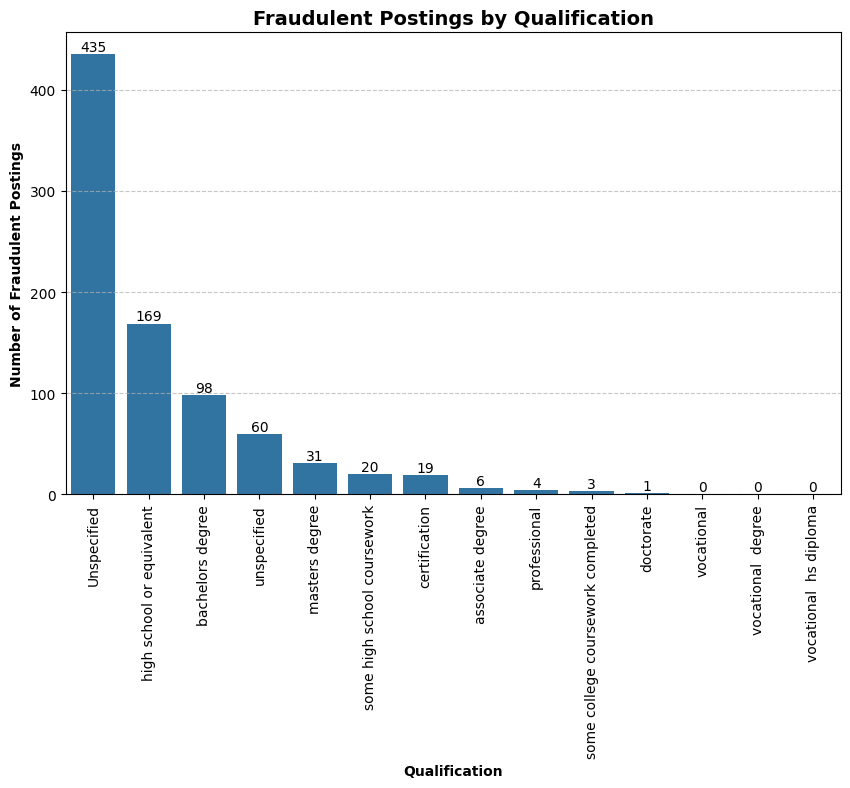

In [119]:

sorted_qualification = df.groupby('Qualification')['Fraudulent'].sum().sort_values(ascending=False).index

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Qualification', y='Fraudulent', estimator=sum, errorbar=None, order=sorted_qualification)
plt.title('Fraudulent Postings by Qualification', fontsize=14, fontweight='bold')
plt.xlabel('Qualification', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')


plt.show()


In [ ]:
df['Qualification'].unique() #why does it show on the graph? last 3?

array([nan, 'bachelors degree', 'masters degree',
       'high school or equivalent', 'unspecified',
       'some college coursework completed', 'vocational', 'certification',
       'associate degree', 'professional', 'doctorate',
       'some high school coursework', 'vocational  degree',
       'vocational  hs diploma'], dtype=object)

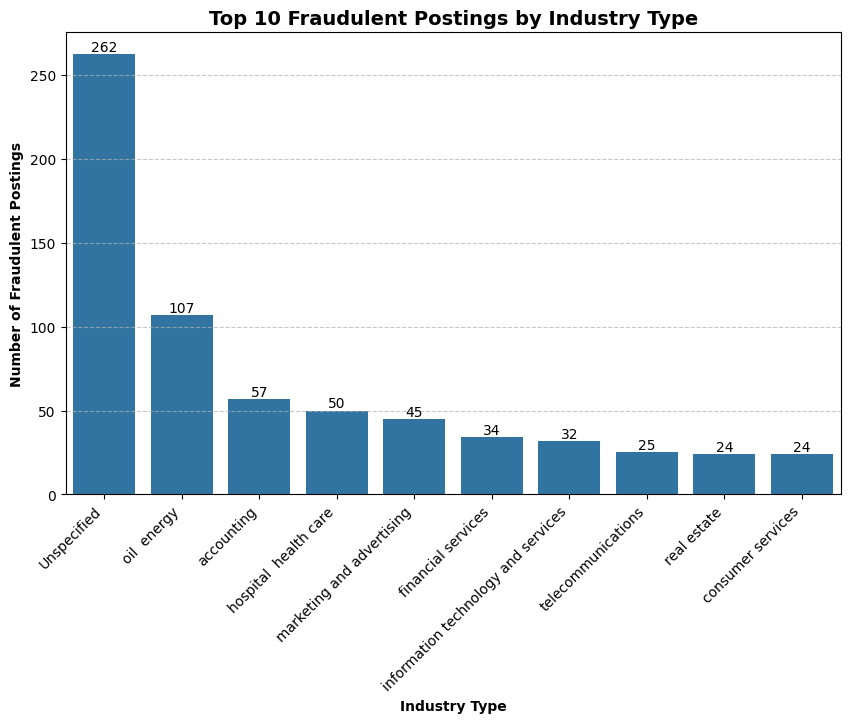

In [124]:
# Top 10 Industries with highest fradulent job posting

top_10_industry = df.groupby('Type_of_Industry')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_industry.index, y=top_10_industry.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Industry Type', fontsize=14, fontweight='bold')
plt.xlabel('Industry Type', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


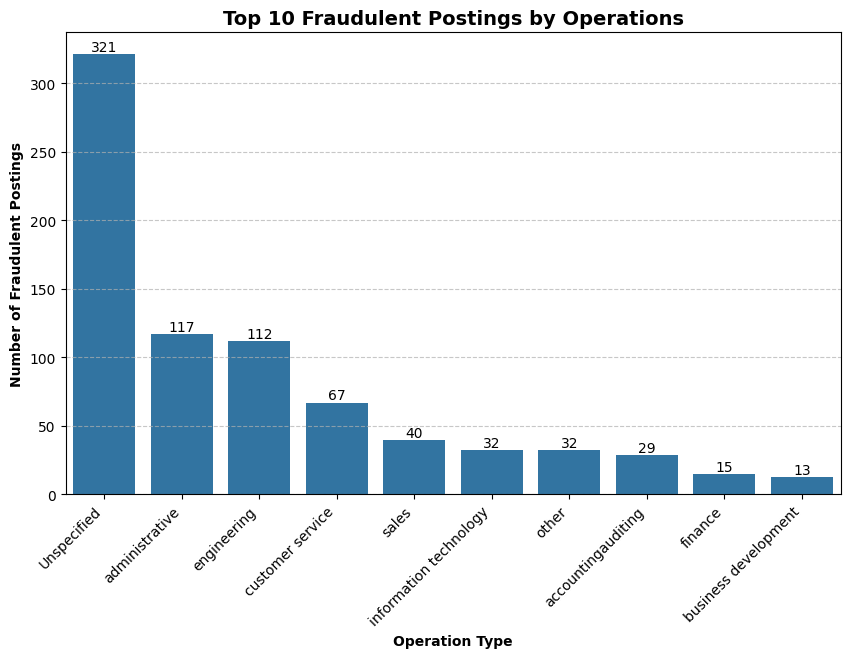

In [125]:
# Top 10 operations with highest fradulent job posting

top_10_operation = df.groupby('Operations')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_operation.index, y=top_10_operation.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Operations', fontsize=14, fontweight='bold')
plt.xlabel('Operation Type', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


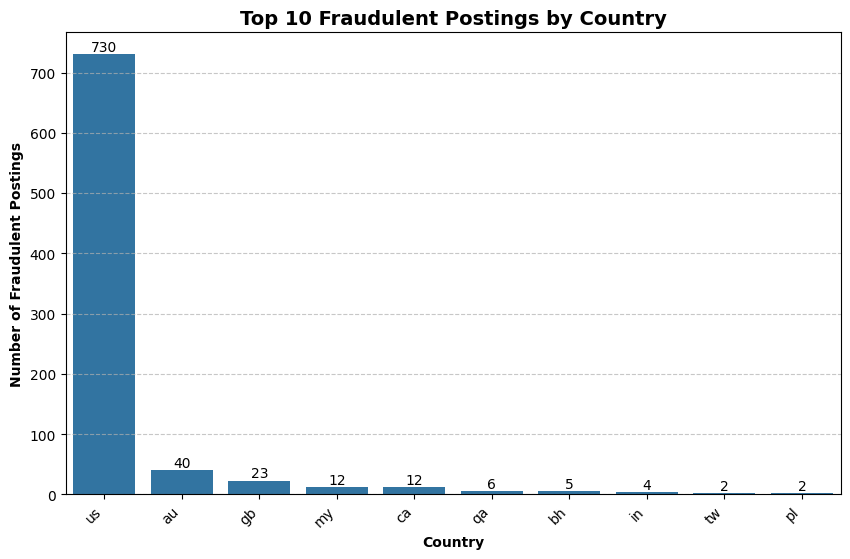

In [126]:
# Top 10 countries with highest fradulent job posting

top_10_country = df.groupby('Country')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_country.index, y=top_10_country.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


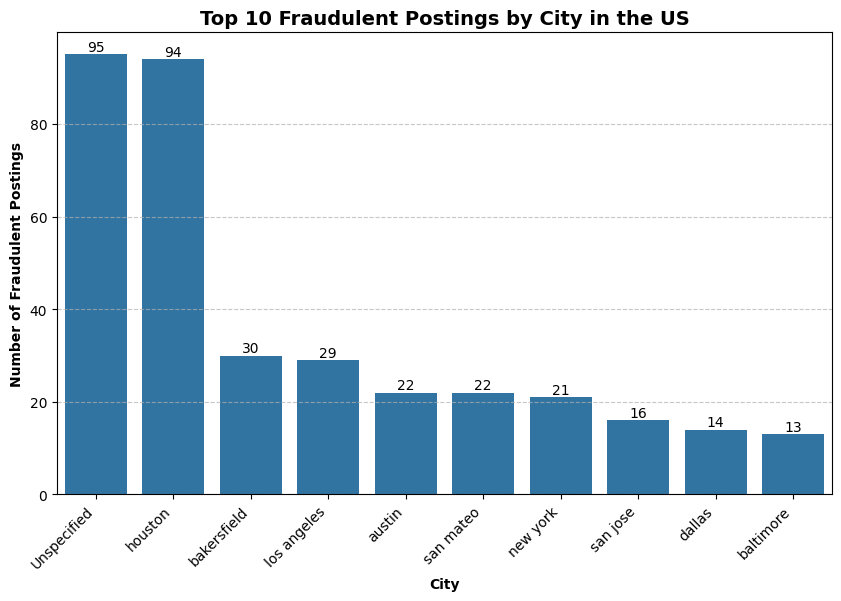

In [127]:
# top 10 city in US with the highest fradulent job posting

df_us = df[df['Country'] == 'us']

top_10_city_fraud = df_us.groupby('City')['Fraudulent'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_city_fraud.index, y=top_10_city_fraud.values, estimator=sum, errorbar=None)
plt.title('Top 10 Fraudulent Postings by City in the US', fontsize=14, fontweight='bold')
plt.xlabel('City', fontweight='bold')
plt.ylabel('Number of Fraudulent Postings', fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()


## Feature Engineering: Converting text features to vectors for modelling

In [49]:
#CAN GROUP THESE TOGETHER FOR ONE HOT
len(df['Qualification'].unique())
df['Qualification'].unique()

array([nan, 'bachelors degree', 'masters degree',
       'high school or equivalent', 'unspecified',
       'some college coursework completed', 'vocational', 'certification',
       'associate degree', 'professional', 'doctorate',
       'some high school coursework', 'vocational  degree',
       'vocational  hs diploma'], dtype=object)

In [25]:
def simplify_qualification(q):
    if pd.isna(q) or q == "unspecified":
        return "Unspecified"
    elif q in ["high school or equivalent", "some high school coursework", "vocational hs diploma"]:
        return "High School"
    elif q in ["vocational", "vocational degree", "certification", "professional"]:
        return "Vocational / Certification/ Professional"
    elif q == "some college coursework completed":
        return "Some College"
    elif q == "associate degree":
        return "Associate Degree"
    elif q == "bachelors degree":
        return "Bachelor's Degree"
    elif q == "masters degree":
        return "Master's Degree"
    elif q == "doctorate":
        return "Doctorate"
    else:
        return "Other"

df['Qualification'] = df['Qualification'].apply(simplify_qualification)

# One-Hot Encode
# df = pd.get_dummies(df, columns=['Qualification_Simplified'], drop_first=True)


In [26]:
# Combined back the words to form sentence for vector embedding
text_columns = ['Profile', 'Job_Description', 'Requirements', 'Job_Benefits']
for col in text_columns:
    # df[col] = df[col].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    df[col] = df[col].str.replace(r'[\[\]\'\",]', '', regex=True)


In [68]:
df.head(5)

,Job Title,Department,Range_of_Salary,Profile,Job_Description,Requirements,Job_Benefits,Telecomunication,Comnpany_Logo,Type_of_Employment,Experience,Qualification,Type_of_Industry,Operations,Fraudulent,Country,State,City
0,marketing intern,marketing,NaN,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management system major plu...,nan,0,1,other,internship,Unspecified,NaN,marketing,0,us,ny,new york
1,customer service cloud video production,success,NaN,90 second world cloud video production service...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part 90 second team gainexperien...,0,1,fulltime,not applicable,Unspecified,marketing and advertising,customer service,0,nz,NaN,auckland
2,commissioning machinery assistant cma,NaN,NaN,valor service provides workforce solution meet...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,nan,0,1,NaN,NaN,Unspecified,NaN,NaN,0,us,ia,wever
3,account executive washington dc,sales,NaN,passion improving quality life geography heart...,company esri â environmental system research i...,educationâ bachelorâs masterâs gi business adm...,culture anything corporateâwe collaborative cr...,0,1,fulltime,midsenior level,Bachelor's Degree,computer software,sales,0,us,dc,washington
4,bill review manager,NaN,NaN,spotsource solution llc global human capital m...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefit offered,0,1,fulltime,midsenior level,Bachelor's Degree,hospital health care,health care provider,0,us,fl,fort worth


## Checking Country City State, seems sus, maybe just use Country only?

In [53]:
len(df['Country'].unique())
df['Country'].unique()

array(['us', 'nz', 'de', 'gb', 'au', 'sg', 'il', 'ae', 'ca', 'in', 'eg',
       'pl', 'gr', 'pk', 'be', 'br', 'sa', 'dk', 'ru', 'za', 'cy', 'hk',
       'tr', 'ie', 'lt', 'jp', 'nl', 'at', 'kr', 'fr', 'ee', 'th', 'pa',
       'ke', 'mu', 'mx', 'ro', 'my', 'fi', 'cn', 'es', 'se', 'cl', 'ua',
       'qa', 'it', 'lv', 'iq', 'bg', 'ph', 'cz', 'vi', 'mt', 'hu', 'bd',
       'kw', 'lu', 'ng', 'rs', 'by', 'vn', 'id', 'zm', 'no', 'bh', 'ug',
       'ch', 'tt', 'sd', 'sk', 'ar', 'tw', 'pt', 'pe', 'co', 'is', 'si',
       'ma', 'am', 'tn', 'gh', 'al', 'hr', 'cm', 'sv', 'ni', 'lk', 'jm',
       'kz', 'kh'], dtype=object)

In [54]:
import pandas as pd
from scipy.stats import chi2_contingency

def categorical_correlation(column):
    contingency_table = pd.crosstab(df[column], df['Fraudulent'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    cramers_v = np.sqrt(chi2 / (len(df) * (min(contingency_table.shape) - 1)))
    return cramers_v

print("Country correlation:", categorical_correlation('Country'))
print("State correlation:", categorical_correlation('State')) 
print("City correlation:", categorical_correlation('City'))

Country correlation: 0.19292954038212332
State correlation: 0.25321538911856023
City correlation: 0.5747512976643746


In [56]:
# Compare models with different geographic granularity
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_country = pd.get_dummies(df['Country'])
X_state = pd.get_dummies(df[['Country', 'State']].fillna('').astype(str).apply('_'.join, axis=1))
X_city = pd.get_dummies(df[['Country', 'State', 'City']].fillna('').astype(str).apply('_'.join, axis=1))

print("Country only CV score:", cross_val_score(RandomForestClassifier(), X_country, df['Fraudulent']).mean())
print("Country+State CV score:", cross_val_score(RandomForestClassifier(), X_state, df['Fraudulent']).mean()) 
print("Full geo CV score:", cross_val_score(RandomForestClassifier(), X_city, df['Fraudulent']).mean())

Country only CV score: 0.9517480237959415
Country+State CV score: 0.951633966196854
Full geo CV score: 0.9509491000884711


## Encodoing

In [ ]:
from sentence_transformers import SentenceTransformer

columns_for_embedding = ['Job Title', 'Profile', 'Department', 'Job_Description', 'Requirements', 'Job_Benefits', 'Type_of_Industry', 'Operations',]
categorical_columns = ['Type_of_Employment','Experience', 'Qualification', 'Country']

model = SentenceTransformer('all-MiniLM-L6-v2')
for col in columns_for_embedding:
    print(f"Embedding column: {col}")
    df[f"{col}_embed"] = model.encode(df[col].fillna(""))

Embedding column: Job Title
Embedding column: Profile
Embedding column: Department
Embedding column: Job_Description
Embedding column: Requirements
Embedding column: Job_Benefits
Embedding column: Type_of_Industry
Embedding column: Operations


In [40]:
df['Profile'].unique()

array([nan, 'Unspecified'], dtype=object)

In [39]:
new_df

,Job Title,Department,Range_of_Salary,Profile,Job_Description,Requirements,Job_Benefits,Telecomunication,Comnpany_Logo,Type_of_Employment,Experience,Qualification,Type_of_Industry,Operations,Fraudulent,Country,State,City
0,-0.045861,-0.054776,Unspecified,-0.118838,-0.118838,-0.118838,-0.010108,0,1,other,internship,Other,-0.010108,-0.054776,0,us,ny,new york
1,-0.024208,-0.008672,Unspecified,-0.118838,-0.118838,-0.118838,-0.118838,0,1,fulltime,not applicable,Other,-0.033716,-0.149438,0,nz,Unspecified,auckland
2,-0.117126,-0.010108,Unspecified,-0.118838,-0.118838,-0.118838,-0.010108,0,1,Unspecified,Unspecified,Other,-0.010108,-0.010108,0,us,ia,wever
3,0.004597,-0.069585,Unspecified,-0.118838,-0.118838,-0.118838,-0.118838,0,1,fulltime,midsenior level,Bachelor's Degree,-0.076391,-0.069585,0,us,dc,washington
4,-0.077730,-0.010108,Unspecified,-0.118838,-0.118838,-0.118838,-0.118838,0,1,fulltime,midsenior level,Bachelor's Degree,-0.024020,-0.089137,0,us,fl,fort worth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,0.035726,-0.069585,Unspecified,-0.118838,-0.118838,-0.118838,-0.118838,0,1,fulltime,midsenior level,Other,-0.076391,-0.069585,0,ca,on,toronto
17529,-0.075184,-0.024759,Unspecified,-0.118838,-0.118838,-0.118838,-0.118838,0,1,fulltime,midsenior level,Bachelor's Degree,-0.015799,0.006420,0,us,pa,philadelphia
17530,-0.069088,-0.010108,Unspecified,-0.118838,-0.118838,-0.118838,-0.010108,0,0,fulltime,Unspecified,Other,-0.010108,-0.010108,0,us,tx,houston
17531,-0.055324,-0.010108,Unspecified,-0.010108,-0.118838,-0.118838,-0.118838,0,0,contract,not applicable,Vocational / Certification/ Professional,-0.003971,-0.052529,0,ng,la,lagos


In [38]:
new_df['Profile'].unique()

array([-0.11883842, -0.01010849, -0.11883846, -0.11883839], dtype=float32)

In [42]:
# Verify the embedding shape
print(new_df['Job Title'].iloc[0].shape)  # Should output (384,)
print(type(new_df['Job Title'].iloc[0]))   # Should output <class 'numpy.ndarray'>

()
<class 'numpy.float32'>
